# Stability analysis of the Linearized Navier-Stokes equations

Here we do data analysis on the linearized navier stokes stuff.

Power iterations in particuylar.

In [310]:
# Assignment of parameters for the notebook
root_folder = '../../'
log_folder = root_folder + 'logs/power_iterations/'
result_folder = root_folder + 'results/power_iterations/'

t_min = 40
t_max = -1


In [311]:
# Import libraries and install if necessary
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

except:
    %pip install numpy matplotlib scipy
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

# If the log folder exists use it, otherwise use results folder
if os.path.exists(log_folder):
    data_folder = log_folder
elif os.path.exists(result_folder):
    data_folder = result_folder
else:
    raise FileNotFoundError('No log or result folder found')

In [312]:
# Read the CSV file

data = np.genfromtxt(data_folder + 'power_iterations.csv',
                     delimiter=',',
                     names=True)

time = data['Time']
norm_u = data['Norm']
# slope = data['Slope']
# eigen = data['Eigenvalue']
scaling_factor = data['Scaling']

eigen = np.zeros(len(time))
slope = np.zeros(len(time))

for i in range(1, len(time)):
    dt = time[i] - time[i - 1]
    eigen[i] = (np.log(norm_u[i]) - np.log(norm_u[i-1])) / dt

slope = np.cumsum(eigen)
slope = slope / range(1, len(time) + 1)

start_index = 0
end_index = -1

for i in [i for i in range(len(time) - 1, 0, -1) if time[i] > t_min]:
    start_index = i
for i in [i for i in range(start_index, len(time)) if time[i] < t_max]:
    end_index = i


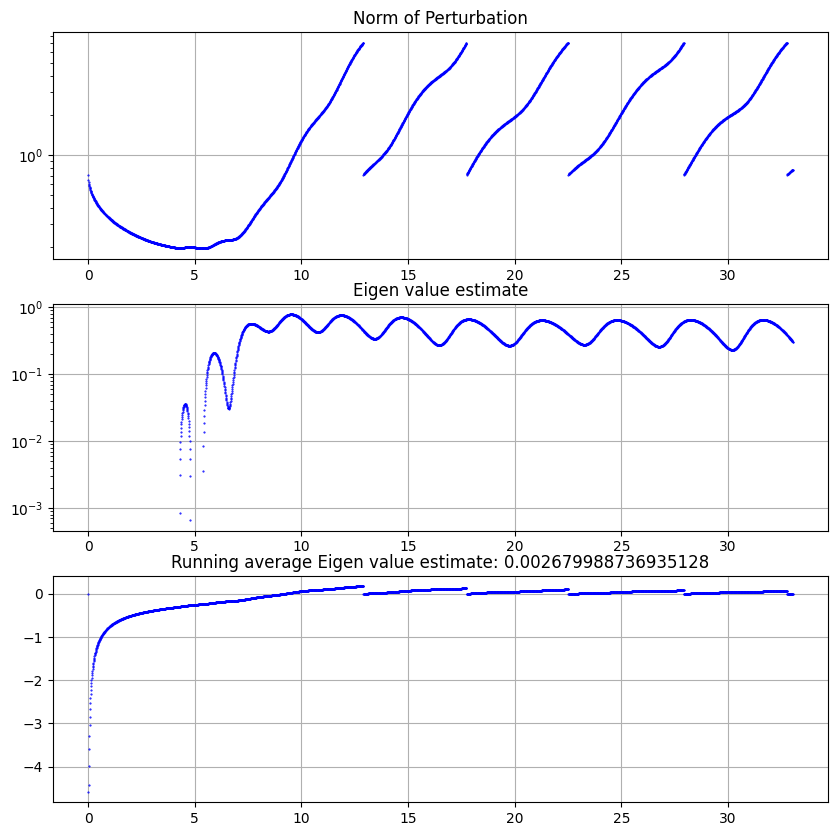

In [313]:
# Plot the data
#
# We wish to inspect the growth of the perturbation norm, the running average of
# the eigenvalue and the eigenvalue estimate.

plt.figure(1, figsize=(10, 10))

a = plt.subplot(311)
a.plot(time, norm_u, 'b.', markersize=1)
a.set_title('Norm of Perturbation')
a.grid()
a.set_yscale('log')

a = plt.subplot(312)
a.plot(time, eigen, 'b.', markersize=1)
a.set_title('Eigen value estimate')
a.grid()
a.set_yscale('log')

a = plt.subplot(313)
# a.plot(time, slope, 'b.', markersize=1)
index_list = [i for i in range(1, len(eigen) + 1)]
a.plot(time, np.cumsum(eigen) / index_list, 'b.', markersize=1)
a.set_title('Running average Eigen value estimate: ' + str(slope[-1]))
# a.set_yscale('log')
a.grid()

plt.show()

# Lets estimate the slope of the line that best fits the data, in a single logarithmic plot

We do need to adjust for the scaling factor, which can be read from the data
file we previously read in. The scaling factor is reported per timestep, so we
need to take the cumulative product of the scaling factors to get the total
scaling factor at each timestep.

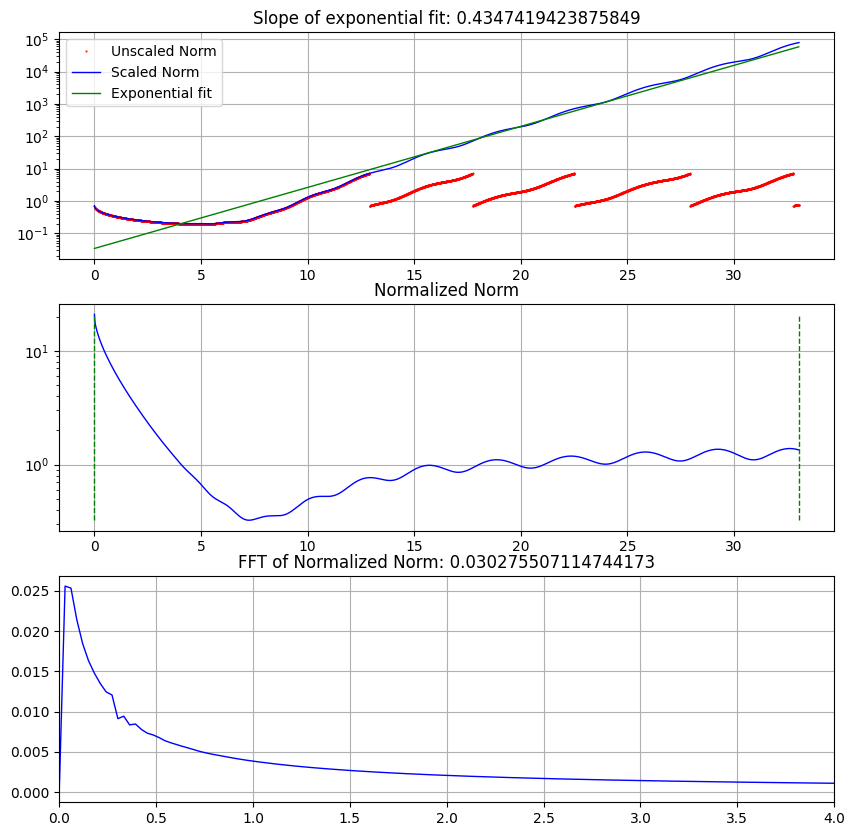

In [314]:
# Compute the scaling factor
scaling = np.cumprod(scaling_factor)
scaled_norms = norm_u / scaling


# Estimate slope of the scaled norm as a linear function in the log space
# y = a * x + b
def func(x, a, b):
    return a * x + b


popt, pcov = curve_fit(func, time[start_index:end_index],
                       np.log(scaled_norms[start_index:end_index]))
a, b = popt

# Plot the data
plt.figure(2, figsize=(10, 10))

ax = plt.subplot(311)
ax.plot(time, norm_u, 'r.', markersize=1, label='Unscaled Norm')
ax.plot(time, scaled_norms, 'b-', label='Scaled Norm', linewidth=1)
# ax.vlines([time[start_index], time[end_index]],
#           scaled_norms.min(),
#           scaled_norms.max(),
#           colors='g',
#           linestyles='dashed',
#           linewidth=1,
#           label='Selected interval')

ax.plot(time[start_index:end_index],
        np.exp(func(time[start_index:end_index], a, b)),
        'g-',
        label='Exponential fit',
        linewidth=1)
ax.set_yscale('log')

ax.legend()
ax.set_title('Slope of exponential fit: ' + str(a))

ax.grid()

# Normalize the norm to look only at oscillations
normalized_norm = scaled_norms / np.exp(func(time, a, b))

ax = plt.subplot(312)
ax.plot(time, normalized_norm, 'b-', label='Normalized Norm', linewidth=1)
ax.vlines([time[start_index], time[end_index]],
          normalized_norm.min(),
          normalized_norm.max(),
          colors='g',
          linestyles='dashed',
          linewidth=1,
          label='Selected interval')

ax.set_title('Normalized Norm')
ax.set_yscale('log')
ax.grid()

# Compute the fft of the normalized norm to find the frequency of the
# oscillations
fft = np.fft.fft(normalized_norm[start_index:end_index] -
                 np.mean(normalized_norm[start_index:end_index]))
fft = fft / fft.sum()
freq = np.fft.fftfreq(len(time[start_index:end_index]), time[1] - time[0])

# Sort the frequency and fft
idx = np.argsort(freq)
freq = freq[idx]
fft = np.abs(fft[idx])

ax = plt.subplot(313)
ax.plot(freq, np.abs(fft), 'b-', label='FFT', linewidth=1)
ax.set_title('FFT of Normalized Norm: ' + str(np.abs(freq[np.argmax(fft)])))
ax.set_xlim([0, 4.0])
ax.grid()
